###  OpenPose model implementation

This notebook is based on OpenPose, the first open-source realtime system for multi-person 2D pose detection, including body, foot, hand, and facial keypoints, by Cao et al. (2018). 

See: Zhe Cao, Gines Hidalgo, Tomas Simon, Shih-En Wei, Yaser Sheikh, "[Computer Vision and Pattern Recognition](https://arxiv.org/abs/1812.08008)," arXiv:1812.08008 [cs.CV] (Dec. 2018).
    
This notebook is largely based on the OPenPose model implementation of Kunal Bhashkar (<bhashkar.brand@gmail.com>) available at: https://github.com/kunalBhashkar/OpenPose-Pose-Estimation

**COCO pose estimation model output format**<BR>
![COCO pose estimation model output format](coco_pose-estimate-model-ouput-format.png)

In [1]:
# Run in pyenv 3.7.0 environment
import cv2     # `$ python -m pip install opencv-python`
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint

In [2]:
protoFile = "Models/Coco/pose_deploy_linevec.prototxt" 
weightsFile = "Models/Coco/pose_iter_440000.caffemodel"        # load weigths, obtained from Bashkar's repo
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']
nPoints = 18
model_pose = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)  # load pre-trained model



pose_pairs = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# PAFs' indices corresponding to 'pose_pairs'
# e.g for pose_pairs(1,2), PAFs are located at indices (31,32) of output
# similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

#colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
#         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
#         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0] ]

colors = [[255,0,0],[255,0,0],[255,153,0],[255,204,51],[102,153,0],[102,255,102],
         [102,255,102],[102,255,102],[102,255,102],[0,204,204],[102,204,255],[51,102,255],
         [0,0,255],[0,0,255],[153,0,255],[255,0,0],[255,0,255],
         [255,255,0],[204,204,0]]

In [3]:
def get_keypoints(probMap, threshold=0.1):
    '''
    Find keypoints using Non-Maximum-Suppression on Confidence Map
    '''
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #contours,hierachy=cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints



Use the following equation for finding valid joint-pairs

In the above equation:

    - L is the PAF (Part Affinity Fields);
To predict where the joints are, it is necessary to know the approximate location and orientation of the limb in whose joints we are interested. Conversely, once paired joint locations become known, the location of the limb and its orientation are determined. Thus, the direction and location of entire limbs, instead of just their joints, are natural things to consider in a body-tracking network.<BR>
To represent such information, we introduce partial affinity fields (PAF), a nonparametric representation,. Each limb is represented on a separate channel of vector fields. So for example, if we include 19 limbs, and our output size is a 100 by 100 picture, then we shall have 19 * 100 * 100 *2 output, or in implementation, 100*100*38 if channels come last.<BR>
Considering two joints j1 and j2 (say right elbow and right wrist, and thus, we are on the channel of the right forearm). We can represent its direction by its unit vector, v=(j-i)/||j-i||.<BR>
This channel's PAF consists of the assignment of a vector to each point of this channel. Points on the limb are assigned v and those who are not will be assigned the null vector(in RxR).

    - d_ij is the vector joining two joints i and j;

    - p is the interpolated point between two joints;

Finding valid joint pairs is implemented using the dot product between the PAF and the vector $d_{ij}$.


In [4]:
def get_validpairs(output):
    '''
    Find valid connections between different joints of all human-like figure or "persons" present
    '''
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1  # PAF score threshold
    conf_th = 0.7       # confidence threshold
    
    # loop on every 'pose_pair'
    for k in range(len(mapIdx)):
        # A->B constitutes a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (width, height))
        pafB = cv2.resize(pafB, (width, height))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[pose_pairs[k][0]]
        candB = detected_keypoints[pose_pairs[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for joint-pair detected, check every candA joint with every candB join 
        # Calculate the distance vector between the two joints
        # Find PAF values at set of interpolated points between joints
        # Use above formula to compute a score to mark connection as valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If fraction of interpolated vectors aligned with PAF > threshold -> Valid Pair  
                    if ( len(np.where( paf_scores > paf_score_th )[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print("\nValid pairs:\n{}".format(valid_pairs))
    return valid_pairs, invalid_pairs

In [5]:
def get_personwise_keypoints(valid_pairs, invalid_pairs):
    '''
    Creates list of keypoints for each detected "person", or human-like figure
    For each detected valid pair, assigns joint(s) to "person"
    Finds "person" and index at which a joint should be added, based on each joint's id.
    '''
    # last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(pose_pairs[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2]+valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints


Processed image: /home/ckb/Documents/Work/Projects/BSC/Sgoab/Data/Processed_images/antonio-allegri-da-coreggio-1532_leda-and-swan.jpg
Image size w x h (pixel): 1019 x 814

Elapsed time (s) = 1.3825528621673584

Keypoints - Nose : [(25, 645, 0.74728614), (43, 540, 0.6867067), (973, 503, 0.7304651), (200, 433, 0.8822223), (781, 433, 0.925004), (482, 398, 0.9188702), (622, 380, 0.7880527), (711, 362, 0.97175896)]
Keypoints - Neck : [(43, 664, 0.6372298), (42, 575, 0.46059856), (958, 521, 0.77341026), (782, 468, 0.77349186), (219, 467, 0.61231), (465, 451, 0.9223235), (588, 398, 0.9149497), (694, 380, 0.78773)]
Keypoints - R-Sho : [(0, 663, 0.60340255), (940, 504, 0.8474733), (764, 468, 0.70548743), (218, 451, 0.508975), (413, 450, 0.74053484), (553, 397, 0.8810654), (677, 397, 0.70189345)]
Keypoints - R-Elb : [(0, 699, 0.18488608), (79, 573, 0.19200285), (922, 557, 0.9221281), (378, 487, 0.79005975), (517, 433, 0.77210015), (712, 415, 0.7593504)]
Keypoints - R-Wr : [(25, 733, 0.26710787)

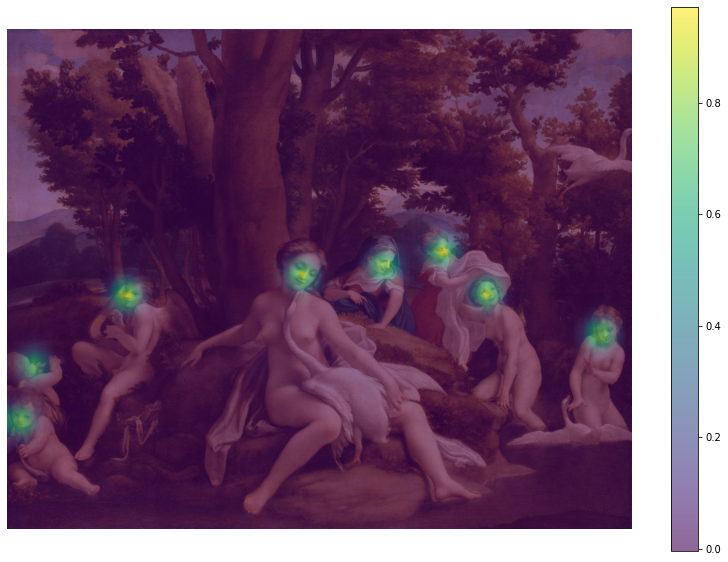

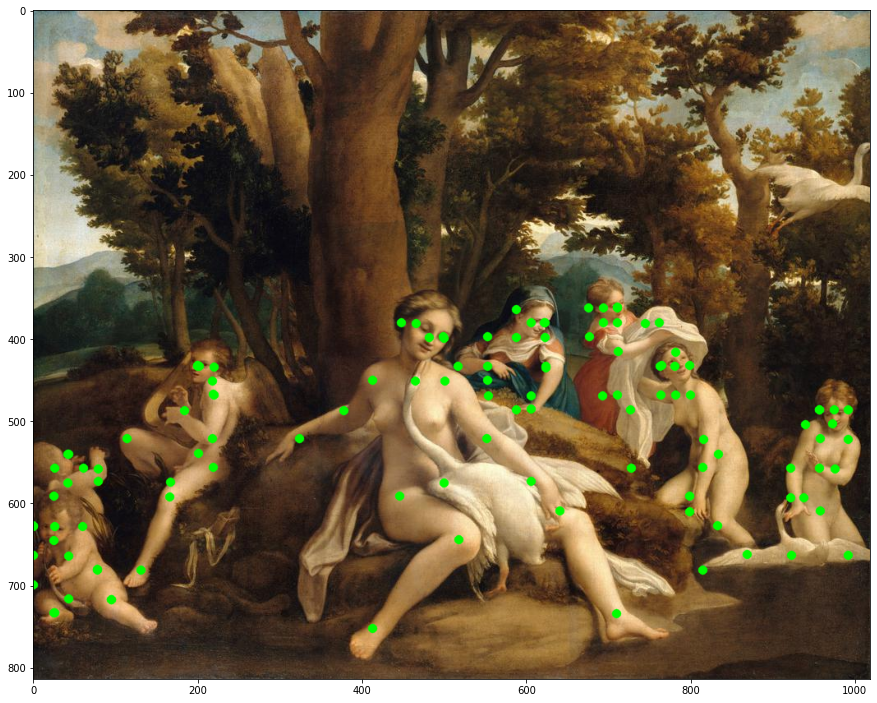

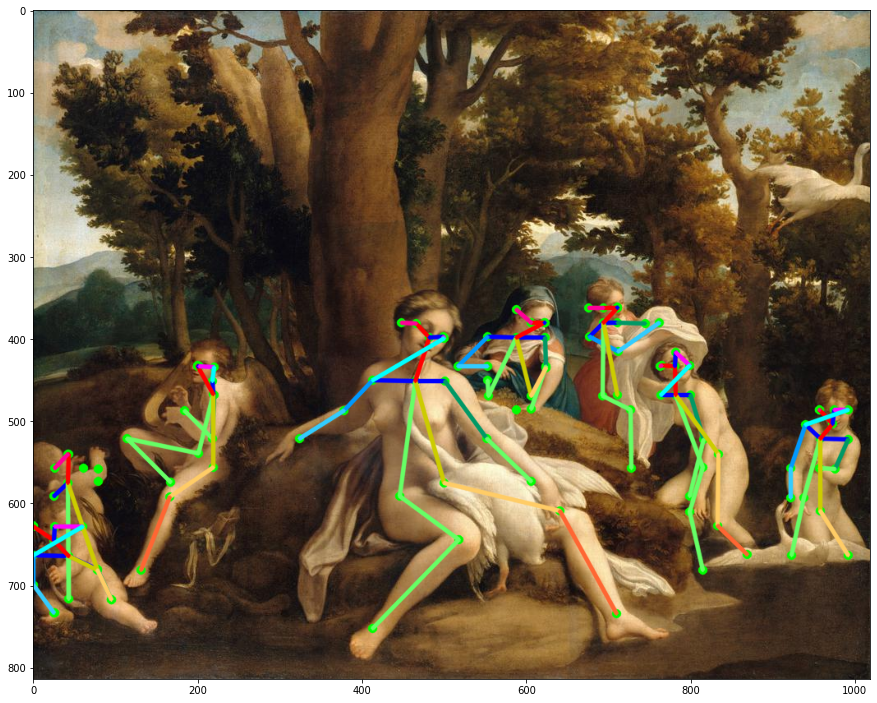

In [6]:
start = time.time()

# For each processed image, ...
img_filein = "/home/ckb/Documents/Work/Projects/BSC/Sgoab/Data/Processed_images/antonio-allegri-da-coreggio-1532_leda-and-swan.jpg"
#img_filein = "/home/ckb/Documents/Work/Projects/BSC/Sgoab/Data/Other_images/00000028.jpg"
img = cv2.imread(img_filein)
width = img.shape[1]
height = img.shape[0]
inHeight = 368
inWidth = int((inHeight/height)*width)
inpBlob = cv2.dnn.blobFromImage(img,1/255,(inWidth,inHeight),(0,0,0),swapRB=False,crop=False)
model_pose.setInput(inpBlob)
output = model_pose.forward()

print("\nProcessed image: {}\nImage size w x h (pixel): {} x {}\n".format(img_filein,width,height))
#print("\nProcessed image: {}\nImage size w x h (pixel): {}\n".format(img_filein,img.shape[:2]))

print("Elapsed time (s) = {}\n".format(time.time()-start))

# plot heatmaps
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (width, height))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

# plot detected keypoints
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (width, height))
    # plt.figure()
    # plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = get_keypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

imgClone = img.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(imgClone, detected_keypoints[i][j][0:2], 5, [0,255,0], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(imgClone[:,:,[2,1,0]])

valid_pairs, invalid_pairs = get_validpairs(output)
personwiseKeypoints = get_personwise_keypoints(valid_pairs, invalid_pairs)

for i in range(nPoints):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(pose_pairs[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(imgClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(imgClone[:,:,[2,1,0]])


